In [1]:
import rioxarray
import rasterio
import numpy as np
import qinfer
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import geopandas as gpd
from shapely.geometry.point import Point
import shapely.affinity
import subprocess
from osgeo import gdal
import pygeos
import json
import os
import pandas as pd
from tqdm import tqdm
import requests
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import esda
import libpysal
from scipy import stats

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/qinfer/parallel.py:51: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [13]:
mi = gpd.read_file('./output/TAS_F_mi.geojson')
mi.T

,0
ID,TX00020
LAT,32.74999
LON,-94.504397
NAME,FERRELLS BRIDGE DAM
LIBRARY_ID,2820
LIBRARY_TYPE,dam_study
I_no_hs_dip,-0.016719
pval_no_hs_dip,0.001424
I_poverty,-0.010494
pval_poverty,0.035788


In [15]:
lm = gpd.read_file('./output/TAS_F_lm.geojson')
lm.head(1)

,no_hs_dip,poverty,unprof_eng,mobile_home,no_vehicle,unemployed,age65,Dam_ID,GEOID,Class,LISA_no_hs_dip,LISA_poverty,LISA_unprof_eng,LISA_mobile_home,LISA_no_vehicle,LISA_unemployed,LISA_age65,geometry
0,31.0,21.0,2.0,30.9,8.1,4.2,24.9,TX00020,050734702002082,0,Not_Sig,Not_Sig,Not_Sig,Not_Sig,Not_Sig,Not_Sig,Not_Sig,"POLYGON ((207444.077 1107922.882, 207444.148 1..."


<AxesSubplot: >

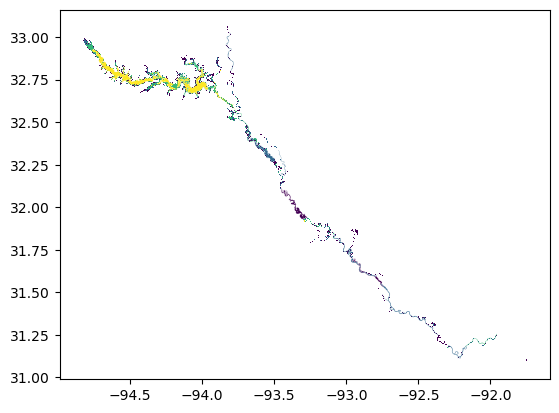

In [12]:
fim = gpd.read_file('./output/TAS_F_fim.geojson')
fim.plot('value')

In [ ]:
ellipse = 

In [5]:
# Import list of dams
fed_dams = requests.get('https://fim.sec.usace.army.mil/ci/fim/getAllEAPStructure').json()
fed_dams = pd.DataFrame(fed_dams)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
fed_dams = fed_dams.loc[fed_dams['ID'].isin(lm['Dam_ID'])]
print(fed_dams.shape[0])
fed_dams

1


,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,geometry
217,TX00020,32.74999,-94.504397,FERRELLS BRIDGE DAM,2820,dam_study,POINT (-94.50440 32.74999)


In [6]:
census_attr_dic = {'no_hs_dip': 'group(B06009)',     # Percentage of people over 25 without high school diploma
                    'poverty': 'group(B17001)',      # Percentage of people below the poverty level
                    'unprof_eng': 'group(B16005)',   # Percentage of resident with no proficient English
                    'mobile_home': 'DP04_0014PE',    # Percentage of mobile homes estimate
                    'no_vehicle': 'DP04_0058PE',     # Percentage of housholds without vehicle available estimate
                    'unemployed': 'DP03_0009PE',   # Unemployment Rate estimate
                    'age65': 'S0101_C02_030E'        # Percentage of person aged 65 and older estimate
                    }

census_attr_dic.keys()

dict_keys(['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65'])

In [3]:
lm = lm.to_crs(epsg=4326)

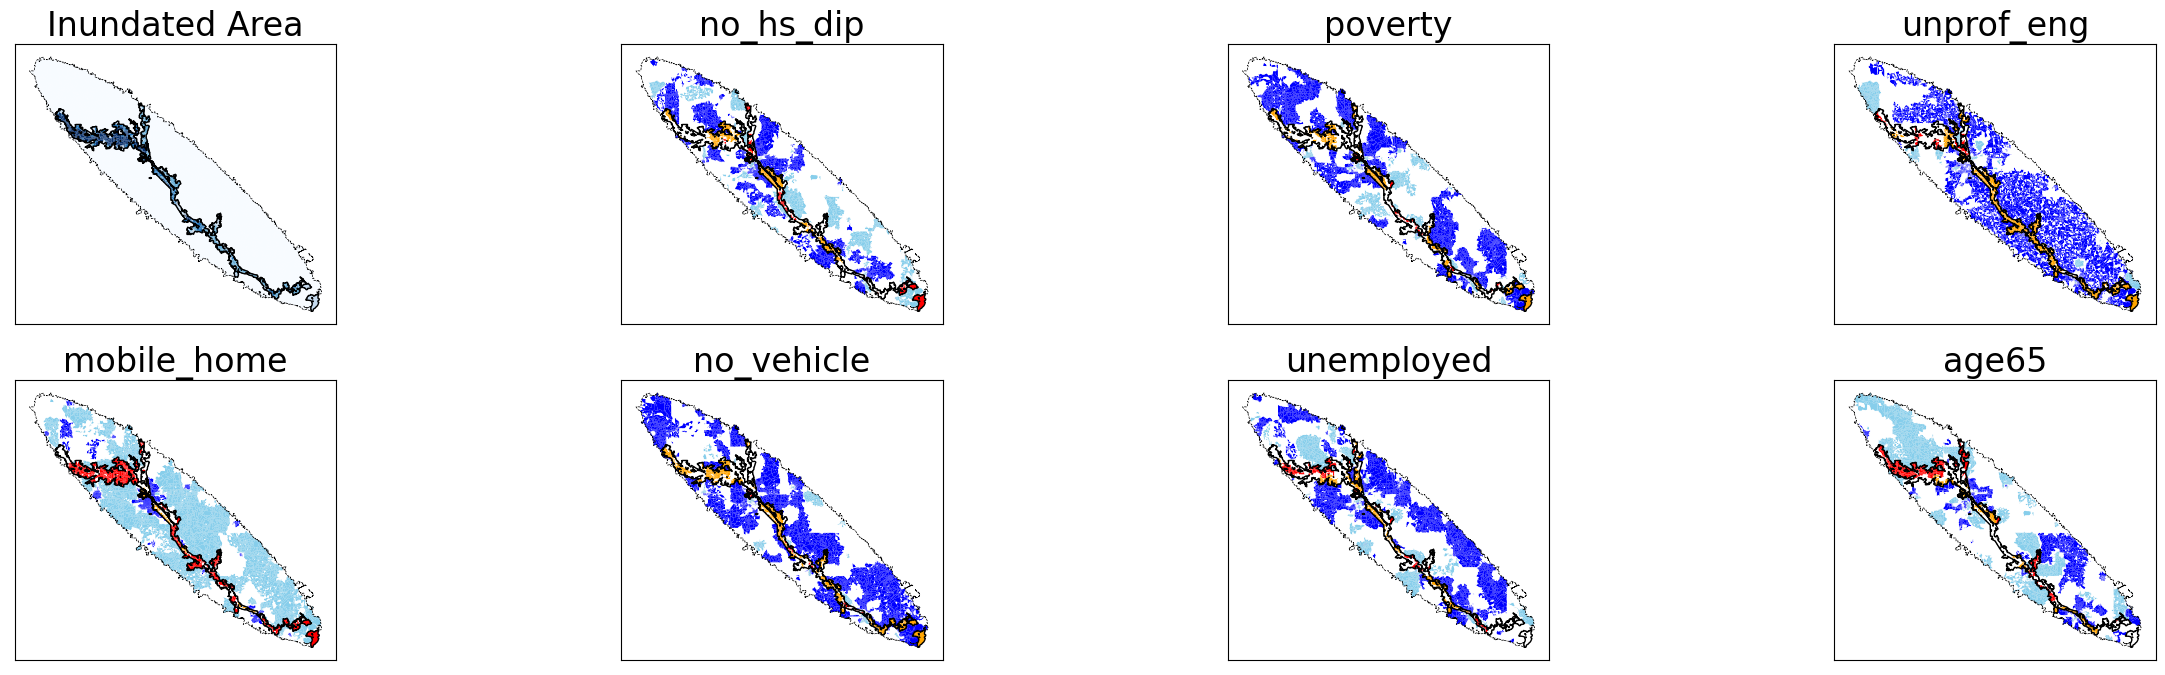

In [7]:
def plot_bivariate_moran_i_and_local_moran_i(dam_id, fim_geoid_gdf):
    fig, axes = plt.subplots(2, 4, figsize=(30, 8))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id].reset_index()

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()
    fed_dams_focus = fed_dams_focus.to_crs(epsg=5070)

    # Plot maps
    var_list = ['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65']
    for m in range(8):
        if m == 0:
            fim_geoid_gdf[fim_geoid_gdf['Dam_ID'] == dam_id].plot('Class', cmap='Blues', ax=ax[m])
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            
            lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}
            
            for key in lisa_color.keys():
                fim_geoid_gdf.loc[(fim_geoid_gdf[f'LISA_{var_list[m-1]}'] == key) & (fim_geoid_gdf['Dam_ID'] == dam_id)].plot(ax=ax[m], color=lisa_color[key], legend=True)
            
            ax[m].set_title(label=f"{var_list[m-1]}", fontsize=24)

        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():

    plot_bivariate_moran_i_and_local_moran_i(dam_id, lm)